In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np

from tslearn.svm import TimeSeriesSVC
from tslearn.utils import to_time_series_dataset
from tqdm import trange

In [3]:
myseed = 13 ** 3 -14
random.seed(myseed)
np.random.seed(myseed)

### Генерация сигналов

In [6]:
def weierstrass_function(x: float | np.ndarray) -> float | np.ndarray:
    a, b = np.float64(3), np.float64(0.5)
    return sum(b ** n * np.cos(a ** n * np.pi * x) for n in range(100))

In [320]:
DURATION = 4  # сек
NUM_SAMPLES = 200
x = np.linspace(-DURATION, DURATION, NUM_SAMPLES)

In [321]:
SIGNALS_1 = [
    weierstrass_function(x) * np.exp(- x * x) * np.sin(x),
    weierstrass_function(x + 0.5) * np.exp(- x * x) * np.sin(x),
    weierstrass_function(x + 0.5) * np.exp(- x * x) * np.sin(x + 0.4),
    weierstrass_function(x + 0.5) * np.exp(- x * x / 2) * np.sin(x + 0.4),
    weierstrass_function(x + 0.0) * np.exp(- x * x / 2) * np.sin(x + 1.3),
    weierstrass_function(x + 1.4) * np.exp(- (x-0.6) * (x-0.6) / 2) * np.sin(x - 1),
    weierstrass_function(x + 1.5) * np.exp(- (x-0) * (x-0.6) / 2) * np.sin(x - 6),
    weierstrass_function(x - 0.1) * np.exp(- (x-0) * (x-0.6) / 10) * np.sin(x - 6),
    weierstrass_function(x - 0.1) * np.exp(- (x-0) * (x-0.6) / 2) * np.sin(x - 3),
    0.5 * weierstrass_function(x + 0.3) * np.exp(- (x-0) * (x-0.6) / 2) * np.sin(x - 5),
]

SIGNALS_2 = [
    np.arctan(np.log(np.abs(weierstrass_function(x / 6))) * np.exp(- (x-0) * (x-0.6) / 2) * np.sin(x - 5) * np.cosh(x)),
    np.arctan(np.log(np.abs(weierstrass_function(x / 6))) * np.exp(- (x-0) * (x-0.6) / 2) * np.sin(x - 2) * np.cosh(x - 0.4)),
    np.arctan(np.log(np.abs(weierstrass_function(x / 2))) * np.exp(- (x-0.4) * (x-0) / 2) * np.sin(x - 4) * np.power(np.cosh(x - 0), 0.01)),
    np.arctan(np.log(np.abs(weierstrass_function(x / 6))) * np.exp(- (x-0.4) * (x-0) / 40) * np.sin(x - 4) * np.power(np.cosh(x - 0), 0.001)),
    np.arctan(np.log(np.abs(weierstrass_function(x / 6))) * np.exp(- (x-0.4) * (x-0) / 40) * np.sin(x - 3) * np.power(np.cosh(x - 0), 0.001)),
    np.arctan(np.log(np.abs(weierstrass_function(x / 2))) * np.exp(- (x-0.4) * (x-0) / 20) * np.sin(x - 3) * np.power(np.cosh(x - 0), 0.001)),
    np.arctan(np.log(np.abs(weierstrass_function(x / 2))) * np.exp(- (x-3) * (x+7) / 20) * np.sin(x - 3) * np.cosh(x / 1000)),
    np.arctan(np.log(np.abs(weierstrass_function(x / 5))) * np.exp(- (x-4) * (x-3) / 20) * np.sin(x - 2.5) * np.cosh((x) / 1000)),
    np.arctan(np.log(np.abs(weierstrass_function(x / 5))) * np.exp(- (x) * (x) / 1) * np.sin(x - 2.5) * np.cosh((x) / 1000)),
    np.arctan(np.log(np.abs(weierstrass_function(x / 6))) * np.exp(- (x) * (x) / 1) * np.sin(x - 2.5) * np.cosh((x) / 10)),
]

### Визуализация сигналов

In [52]:
def visualize_plot(x: np.ndarray, y: list[np.ndarray], shift: float = DURATION) -> None:
    cols_num = len(y)
    nrows = int(np.ceil(np.sqrt(cols_num)))
    ncols = int(np.ceil(cols_num / nrows))

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))
    for ax, column in zip(axes.reshape(-1), y):
        ax.plot(x + shift, column)

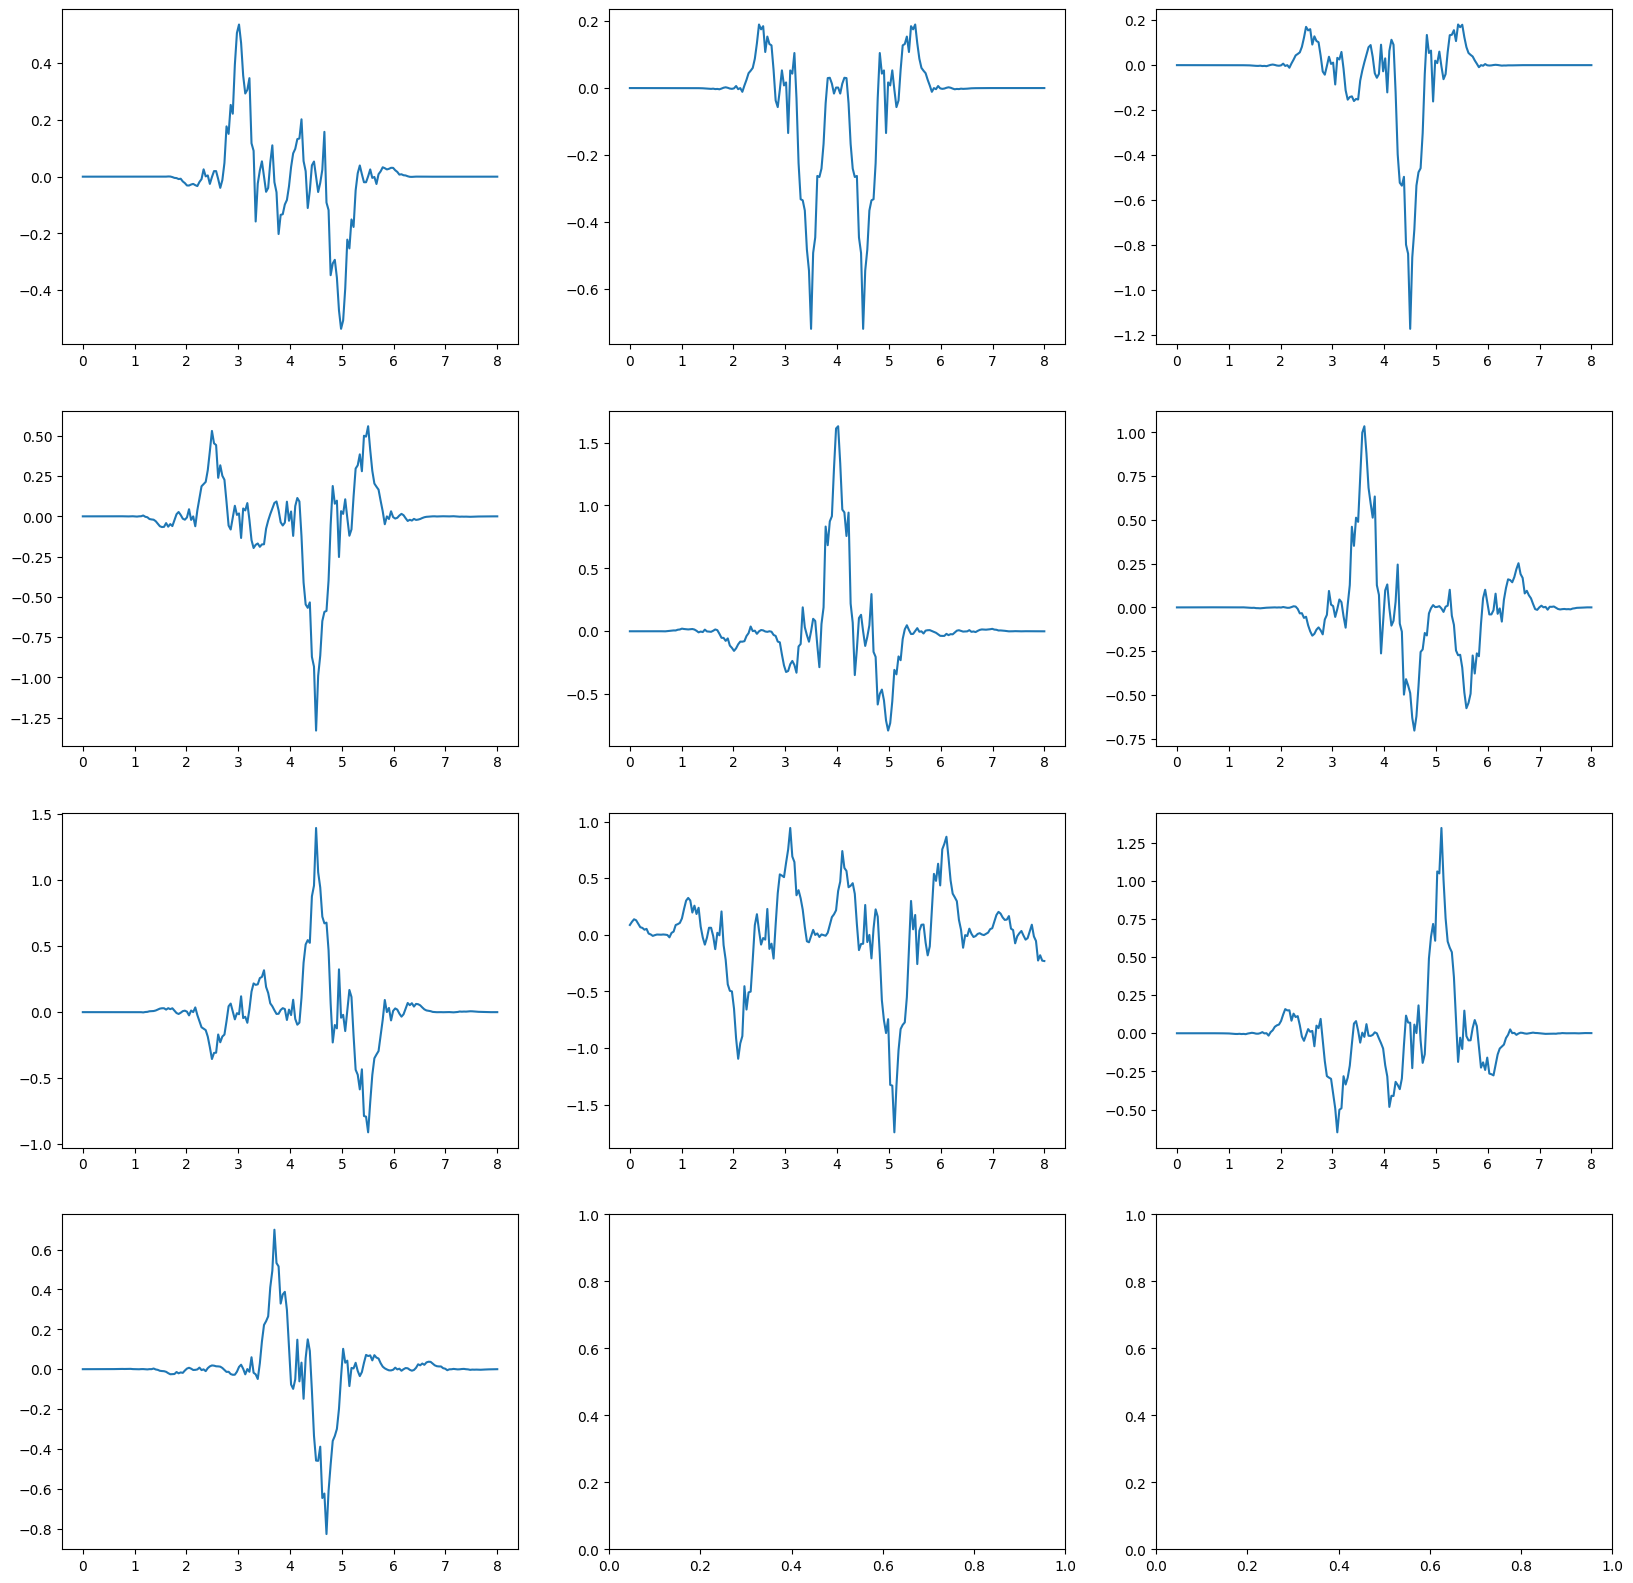

In [322]:
visualize_plot(x, SIGNALS_1)

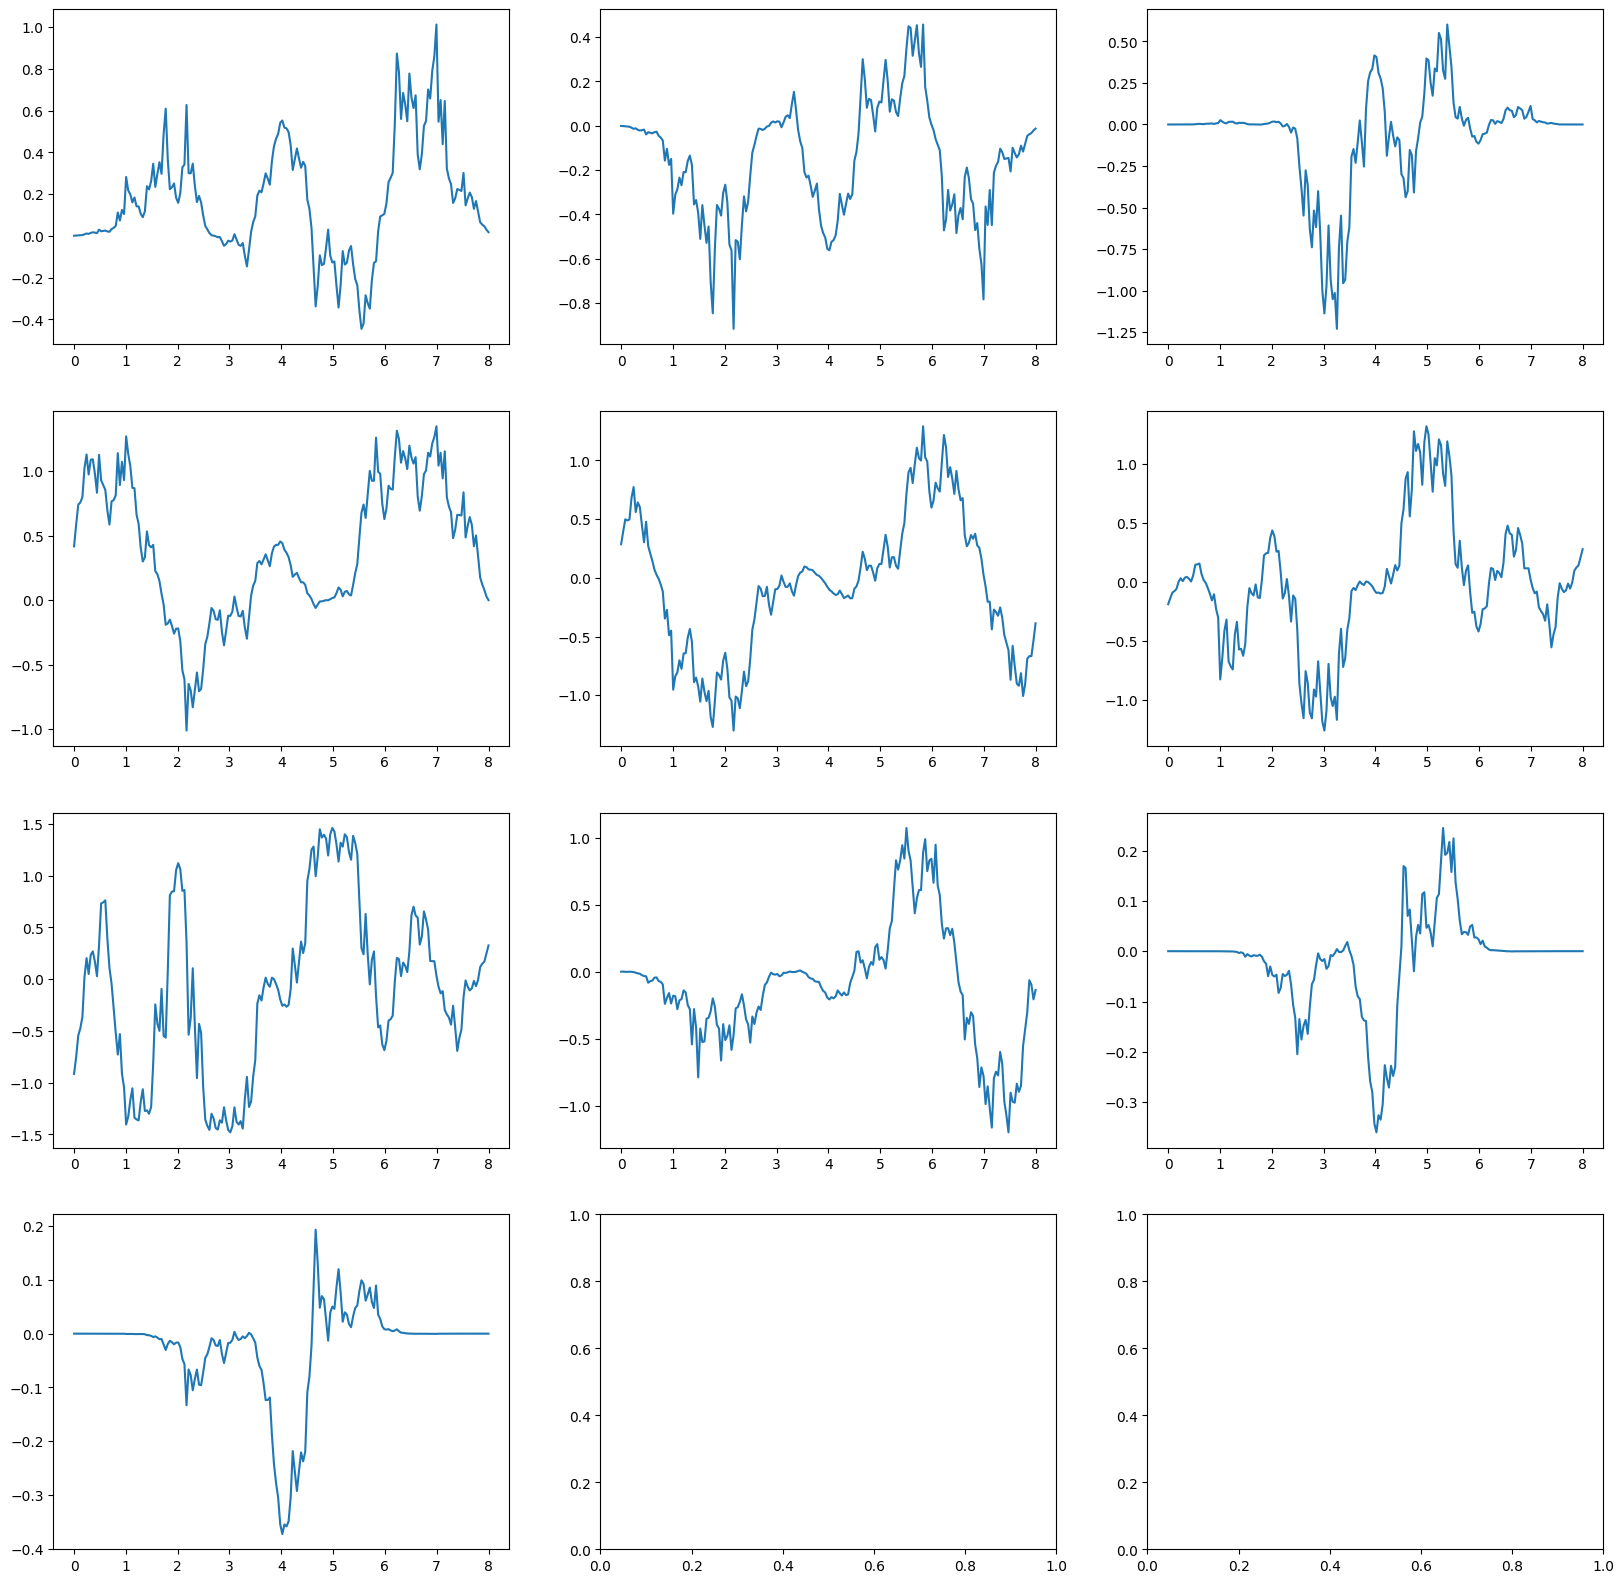

In [323]:
visualize_plot(x, SIGNALS_2)

### Генерация шейплетов

In [13]:
def euclidean_distances(x, y):
    z = x - y
    return np.sqrt(np.einsum("ijk,ijk->ij", z, z))


def min_dist(x, y):
    return np.min(euclidean_distances(x, y), axis=1)

In [15]:
def get_max_info_gain(shapelet, ds):
    ds = sorted(ds, key=lambda x: x[0])

    entropy = -0.5 * np.log(0.5) * 2
    max_info_gain = 0

    for j in range(len(ds) - 1):
        cand_thr = (ds[j][0] + ds[j + 1][0]) / 2
        tp, tn, fp, fn = 0, 0, 0, 0
        for i in range(len(ds)):
            if ds[i][0] < cand_thr:
                if shapelet.cls == ds[i][1]:
                    tp += 1
                else:
                    fp += 1
            else:
                if shapelet.cls == ds[i][1]:
                    tn += 1
                else:
                    fn += 1

        el1 = 0 if tp == 0 else -tp / (tp + fp) * np.log(tp / (tp + fp))
        el2 = 0 if fp == 0 else -fp / (tp + fp) * np.log(fp / (tp + fp))
        er1 = 0 if tn == 0 else -tn / (tn + fn) * np.log(tn / (tn + fn))
        er2 = 0 if fn == 0 else -fn / (tn + fn) * np.log(fn / (tn + fn))

        el = el1 + el2
        er = er1 + er2

        info_gain = entropy - (tp + fp) / len(ds) * \
            el - (tn + fn) / len(ds) * er
        if info_gain > max_info_gain:
            max_info_gain = info_gain
    return max_info_gain

In [211]:
def shapelet_cached_selection(arr, mnm, mxm):
    class Shapelet:
        def __init__(self, values, left, right, cls):
            self.values = values
            self.left = left
            self.right = right
            self.cls = cls

    k = 0
    for ts_mark in arr:
        for ts in ts_mark[0]:
            k += int((len(ts) - mnm + 1) * (len(ts) - mnm + 2) / 2)
            k -= int((len(ts) - mxm) * (len(ts) - mxm + 1) / 2)
    k = int(k * 0.001)  # top 0.1% best shapelets for each time series
    k_shapelets = []

    for ts_mark in arr:
        for ts in ts_mark[0]:
            shapelets = []
            ts_len = len(ts)
            for l in trange(mnm, mxm + 1):

                slices = [
                    np.arange(
                        i,
                        i +
                        l) for i in np.arange(
                        arr[0][0].shape[1] -
                        l +
                        1)]
                y0 = np.array(arr[0][0][:, slices])
                y1 = np.array(arr[1][0][:, slices])

                for i in range(ts_len - l + 1):
                    shapelet = Shapelet(ts[i:i + l], i, i + l - 1, ts_mark[1])

                    ds = [
                        *[[x, arr[0][1]]
                            for x in min_dist(shapelet.values, y0)],
                        *[[x, arr[1][1]] for x in min_dist(shapelet.values, y1)]
                    ]
                    quality = get_max_info_gain(shapelet, ds)
                    shapelets.append([quality, shapelet])

            shapelets = sorted(shapelets, key=(lambda x: -x[0]))
            ids = []
            for i in range(len(shapelets)):
                f = True
                for j in ids:
                    flr = shapelets[i][1].right <= shapelets[j][1].left
                    frl = shapelets[j][1].right <= shapelets[i][1].left
                    f = f and (frl or flr)
                    if not (f):
                        break
                if f:
                    ids.append(i)
            for i in ids:
                k_shapelets.append(shapelets[i])
    k_shapelets_class0 = list(filter(lambda x: x[1].cls == 0, k_shapelets))
    k_shapelets_class1 = list(filter(lambda x: x[1].cls == 1, k_shapelets))
    k_shapelets_class0 = sorted(
        k_shapelets_class0,
        key=(
            lambda x: x[0]),
        reverse=True)[
            :k]
    k_shapelets_class1 = sorted(
        k_shapelets_class1,
        key=(
            lambda x: x[0]),
        reverse=True)[
            :k]
    k_shapelets = k_shapelets_class0 + k_shapelets_class1
    random.shuffle(k_shapelets)
    return (lambda x: [[x[i][1].values, x[i][1].cls]
            for i in np.arange(len(x))])(k_shapelets)

In [297]:
ts_list = [
    [np.apply_along_axis(lambda x: x +
     np.random.normal(0, 0.005, len(x)), 0, SIGNALS_1), 0],
    [np.apply_along_axis(lambda x: x +
     np.random.normal(0, 0.005, len(x)), 0, SIGNALS_2), 1]
]
shapelets = shapelet_cached_selection(ts_list, 10, 30)

100%|██████████| 21/21 [00:01<00:00, 19.79it/s]


### Отобранные шейплеты

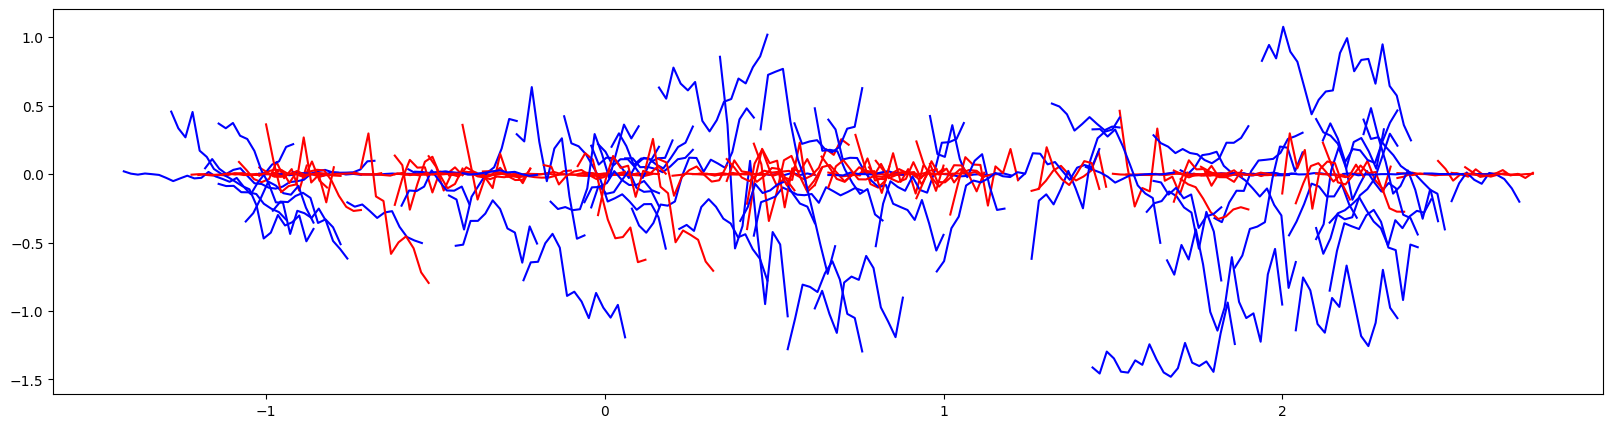

In [318]:
plt.figure(figsize=(20, 5))
for s, cls in shapelets:
    t = np.random.randint(200 - len(s))
    plt.plot(np.linspace((t - len(s) - 50) / 50,
             (t - 50) / 50, len(s)), s, ['r', 'b'][cls])
plt.show()

### Классификация

In [300]:
indexes = np.arange(len(shapelets))
np.random.shuffle(indexes)

train_x, train_y, test_x, test_y = [], [], [], []

train_cutoff = int(len(shapelets) * 0.8)

for idx in indexes[:train_cutoff]:
    train_x.append(shapelets[idx][0])
    train_y.append(shapelets[idx][1])

for idx in indexes[train_cutoff:]:
    test_x.append(shapelets[idx][0])
    test_y.append(shapelets[idx][1])

In [301]:
train_x = to_time_series_dataset(train_x)
test_x = to_time_series_dataset(test_x)

In [310]:
clf = TimeSeriesSVC(C=1.0, kernel="gak")
clf.fit(train_x, train_y)

TimeSeriesSVC()

In [311]:
print(f"Accuracy {clf.score(to_time_series_dataset(test_x), test_y)}")

Accuracy 0.9032258064516129
